In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns

import warnings


%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')


In [2]:
dataset_path = "..//datos//"
abnb_users_curated = "modified_train_users.csv"

In [3]:

users_df = pd.read_csv( dataset_path + abnb_users_curated)

In [4]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(users_df),' users.')

The dataset contains:  121070  users.


In [5]:
users_df.head()

,Unnamed: 0,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,...,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,total_seconds,average_seconds,total_sessions,number_of_devices,has_booked
0,1,820tgsjxq7,1306281600,1243100889,-9223372037,1,38.0,1,0,5,...,6,2,3,7,0,0.0,0.0,1,1,False
1,2,4ft3gnwmtx,1285632000,1244589167,1280707200,0,56.0,0,3,5,...,6,2,6,14,1,0.0,0.0,1,1,True
2,3,bjjt8pjhuk,1323043200,1256968889,1347062400,0,42.0,1,0,5,...,6,2,3,13,2,0.0,0.0,1,1,True
3,4,87mebub9p4,1284422400,1260252665,1266451200,2,41.0,0,0,5,...,6,2,3,7,1,0.0,0.0,1,1,True
4,6,lsw9q7uk0j,1262390400,1262395558,1262649600,0,46.0,0,0,5,...,6,2,3,30,1,0.0,0.0,1,1,True


Vamos a comenzar a trabajar con un subconjunto de usuarios.  
En este caso, usuarios que hicieron reserva (pero que no fueron a USA)  
Como esto no sirvio, vamos a armar destino USA, destino Europa, destino Resto

In [6]:
country_dict = {
    'NDF': 0,
    'US': 1,
    'other': 2,
    'FR': 3,
    'CA': 4,
    'GB': 5,
    'ES': 6,
    'IT': 7,
    'PT': 8,
    'NL': 9,
    'DE': 10,
    'AU': 11
}

europe_set = {3,5,6,7,8,9,10}
north_america_set = {4}
oceania_set = {11}
usa_set = {1}
other_set = {2}

europe_region = 0
north_america_region = 1
oceania_region = 2
usa_region = 3
other_region = 4
no_region = 5

def assign_region( country ):
    if country in europe_set:
        return europe_region
    
    if country in north_america_set:
        return north_america_region
    
    if country in oceania_set:
        return oceania_region
    
    if country in usa_set:
        return usa_region

    if country in other_set:
        return other_region
    
    return no_region
    

In [7]:
users_df['region_destination'] = users_df['country_destination'].apply(lambda x: assign_region(x))

users_who_booked = users_df[ users_df['has_booked'] == True ]

print( "Number of records: ", len(users_who_booked))
users_who_booked.head()

Number of records:  66836


,Unnamed: 0,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,...,signup_app,first_device_type,first_browser,country_destination,total_seconds,average_seconds,total_sessions,number_of_devices,has_booked,region_destination
1,2,4ft3gnwmtx,1285632000,1244589167,1280707200,0,56.0,0,3,5,...,2,6,14,1,0.0,0.0,1,1,True,3
2,3,bjjt8pjhuk,1323043200,1256968889,1347062400,0,42.0,1,0,5,...,2,3,13,2,0.0,0.0,1,1,True,4
3,4,87mebub9p4,1284422400,1260252665,1266451200,2,41.0,0,0,5,...,2,3,7,1,0.0,0.0,1,1,True,3
4,6,lsw9q7uk0j,1262390400,1262395558,1262649600,0,46.0,0,0,5,...,2,3,30,1,0.0,0.0,1,1,True,3
5,7,0d01nltbrs,1262476800,1262546345,1263340800,0,47.0,0,0,5,...,2,3,30,1,0.0,0.0,1,1,True,3


In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)    
    
    #plt.xlim(0, 5)
   # plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
    

In [10]:
# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set_xlabel('gender')
    ax.set_ylabel('region')
    
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['gender'], clustered['region_destination'], c=clustered['group'], s=20, cmap=cmap)
    


In [11]:
def add_cluster_to_dataset( original_df, predictions):
    return  pd.concat([original_df.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

In [12]:
# Let's turn our dataset into a list

X = users_who_booked [['gender','region_destination']].values

In [14]:
def cluster_show_by_age_region( clustered ):

#    fig = plt.figure(figsize=(8,8))
#    ax = fig.add_subplot(111)
#    ax.set_xlabel('age')
#    ax.set_ylabel('region')

#    plt.scatter(clustered['age'], clustered['region_destination'], label='group', c=clustered['group'], s=20)
#    plt.scatter(clustered['age'], clustered['region_destination'], 
#                label=, c=clustered['group'], s=20,
#               marker='o')
 
#    plt.legend(loc=2)
#    plt.show()   

    sns.set(style="white")
    sns.relplot(x="age", y="region_destination", hue="group",
            sizes=(40, 400), alpha=.5,
            height=6, data=clustered)

# Clustering

In [13]:
# Import KMeans
from sklearn.cluster import KMeans


In [15]:
def kmeans_generate_predictions( n_clusters ):
    # Create an instance of KMeans to find two clusters
    kmeans = KMeans(n_clusters)

    # Use fit_predict to cluster the dataset
    predictions = kmeans.fit_predict(X)
    
    return predictions

## K = 2

In [16]:
predictions = kmeans_generate_predictions( 2 )

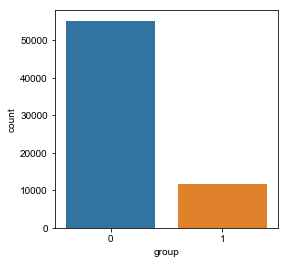

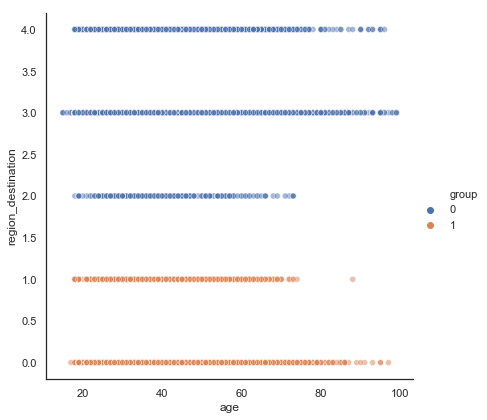

In [17]:
plt.figure(figsize=(4,4))
sns.countplot(data=pd.DataFrame({'group':predictions}), x='group')

clustered = add_cluster_to_dataset(users_who_booked, predictions)

cluster_show_by_age_region( clustered ) 

## K = 3

In [18]:
predictions = []
clustered = []

predictions = kmeans_generate_predictions( 3 )

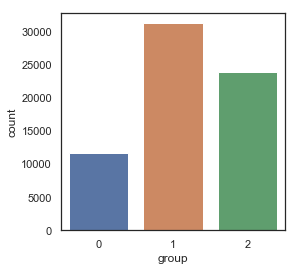

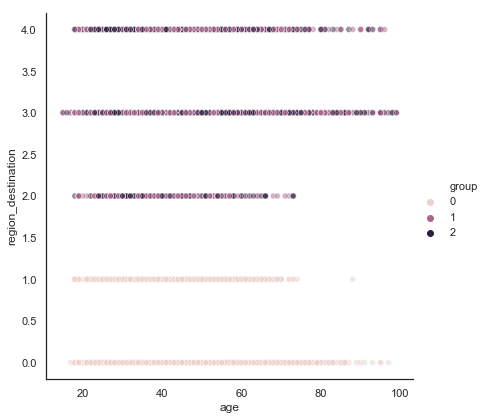

In [19]:
clustered = add_cluster_to_dataset(users_who_booked, predictions)

plt.figure(figsize=(4,4))
sns.countplot(data=pd.DataFrame({'group':predictions}), x='group')

cluster_show_by_age_region( clustered ) 

## K = 4

In [29]:
predictions = []
clustered = []

predictions = kmeans_generate_predictions( 4 )

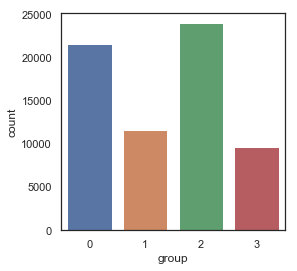

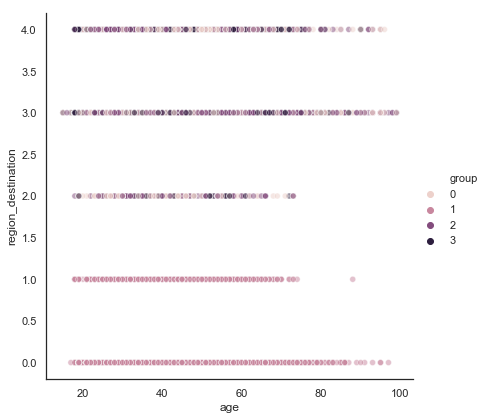

In [30]:
clustered = add_cluster_to_dataset(users_who_booked, predictions)

plt.figure(figsize=(4,4))
sns.countplot(data=pd.DataFrame({'group':predictions}), x='group')

cluster_show_by_age_region( clustered ) 

## K = 5

In [31]:
predictions = []
clustered = []

predictions = kmeans_generate_predictions( 5 )

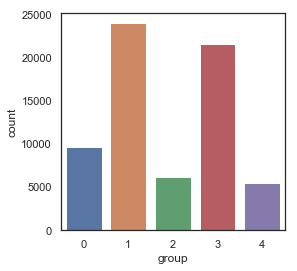

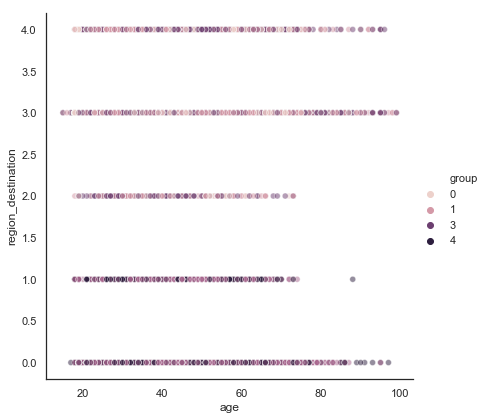

In [32]:
clustered = add_cluster_to_dataset(users_who_booked, predictions)

plt.figure(figsize=(4,4))
sns.countplot(data=pd.DataFrame({'group':predictions}), x='group')

cluster_show_by_age_region( clustered ) 

KeyboardInterrupt: 

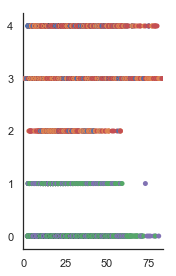

In [33]:
# este grafico no termina...
sns.catplot(x="age", y="region_destination", hue="group", kind="swarm",
            data=clustered, 
            height=4, aspect=.7)